# Q1

7078
1.05 23.86
0 th iteration :  0.27654722332954407
50 th iteration :  0.04944133013486862
100 th iteration :  0.008863790892064571
150 th iteration :  0.008538622409105301
200 th iteration :  0.007572091184556484
250 th iteration :  0.004630644340068102
300 th iteration :  0.0008025209535844624
350 th iteration :  0.00047132078907452524
400 th iteration :  0.00044619751861318946
450 th iteration :  0.0005178741412237287
500 th iteration :  0.00047306736814789474
550 th iteration :  0.0004185734724160284
600 th iteration :  0.00022899365285411477
650 th iteration :  0.00040852653910405934
700 th iteration :  0.00010194625792792067
750 th iteration :  0.000213041523238644
800 th iteration :  0.0001225891464855522
850 th iteration :  0.00013548231800086796
900 th iteration :  0.0002022126136580482
950 th iteration :  0.0001435001177014783
1000 th iteration :  0.00025173695757985115
1050 th iteration :  0.00043656417983584106
1100 th iteration :  0.00018199394980911165
1150 th iteration

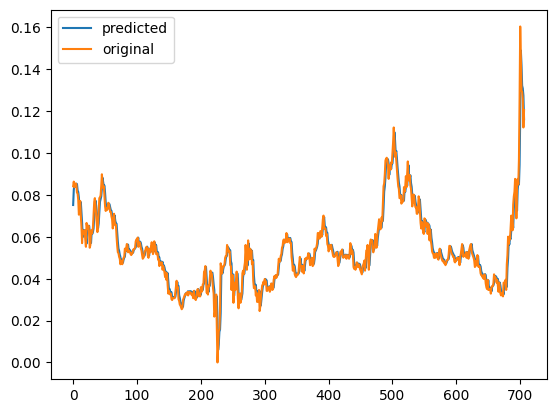

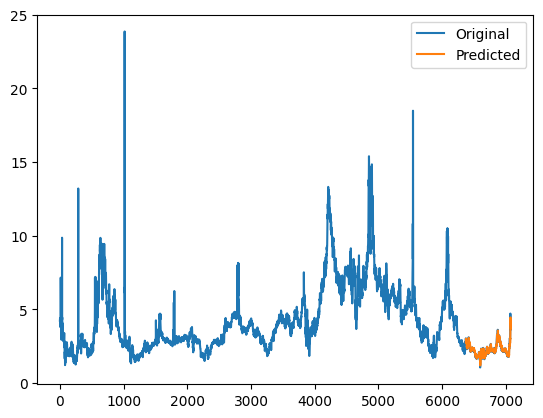

In [2]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch import nn

df = pd.read_csv("./data/flat-ui__data-Tue Mar 18 2025.csv")
df = df.dropna()
y = df['Price'].values
x = np.arange(1, len(y) + 1, 1) 
print(len(y))
minm = y.min()
maxm = y.max()
print(minm, maxm)
y = (y - minm) / (maxm - minm)
Sequence_Length = 10
X = []
Y = []
for i in range(len(y) - Sequence_Length - 1): 
    list1 = []
    for j in range(i, i + Sequence_Length):
        list1.append(y[j])
    X.append(list1)
    Y.append(y[i + Sequence_Length])
X = np.array(X)
Y = np.array(Y)
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size=0.10, random_state=42, shuffle=False)

class NGTimeSeries(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
        self.len = x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.len

dataset = NGTimeSeries(x_train, y_train)
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset, shuffle=True, batch_size=256)

class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()  # Corrected class name here
        self.lstm = nn.LSTM(input_size=1, hidden_size=5, num_layers=1, batch_first=True)
        self.fc1 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        output, _ = self.lstm(x)
        output = output[:, -1, :]
        output = self.fc1(torch.relu(output))
        return output

model = LSTMModel()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
epochs = 1500

for i in range(epochs):
    for j, data in enumerate(train_loader):
        y_pred = model(data[0].view(-1, Sequence_Length, 1)).reshape(-1)  
        loss = criterion(y_pred, data[1])  
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if i % 50 == 0:
        print(i, "th iteration : ", loss.item()) 

test_set = NGTimeSeries(x_test, y_test)
test_pred = model(test_set[:][0].view(-1, 10, 1)).view(-1)
plt.plot(test_pred.detach().numpy(), label='predicted')
plt.plot(test_set[:][1].view(-1).numpy(), label='original') # Added .numpy()
plt.legend()
plt.show()

y = y * (maxm - minm) + minm
y_pred = test_pred.detach().numpy() * (maxm - minm) + minm
plt.plot(y, label = "Original")
plt.plot(range(len(y) - len(y_pred), len(y)), y_pred, label = "Predicted")
plt.legend()
plt.show()


# Q2

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip


--2025-03-25 09:39:03--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.161.229.84, 18.161.229.113, 18.161.229.118, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.161.229.84|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  6.20MB/s    in 0.4s    

2025-03-25 09:39:04 (6.20 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/

In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import glob
import os
import string
import unicodedata
import random

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in string.ascii_letters + " .,;'"
    )

def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

category_lines = {}
all_categories = []
for filename in glob.glob('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2, dropout=0.2, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.dropout = nn.Dropout(0.2)

    def forward(self, input, hidden):
        output, hidden = self.lstm(input.view(1, -1, n_letters), hidden)
        output = self.fc(self.dropout(output[:, -1, :]))  
        return output, hidden

    def initHidden(self):
        return (torch.zeros(2, 1, self.hidden_size),  
                torch.zeros(2, 1, self.hidden_size))

def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i], category_i

def randomTrainingExample():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    return category, line

def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        tensor[li][0][letterToIndex(letter)] = 1
    return tensor

def targetTensor(category_index):
    return torch.tensor([category_index], dtype=torch.long)

def letterToIndex(letter):
    return all_letters.find(letter)

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

n_hidden = 256 
lstm = LSTMClassifier(n_letters, n_hidden, n_categories)
learning_rate = 0.001 
optimizer = optim.Adam(lstm.parameters(), lr=learning_rate) 
criterion = nn.CrossEntropyLoss()

n_iters = 200000 
print_every = 500
plot_every = 100

current_loss = 0
all_losses = []

best_loss = float('inf')
patience = 20000  
patience_counter = 0

def train(category_tensor, line_tensor):
    hidden = lstm.initHidden()
    optimizer.zero_grad()

    output, hidden = lstm(line_tensor, hidden)
    output = output.view(1, -1)  

    loss = criterion(output, category_tensor)
    loss.backward()
    optimizer.step()

    return output, loss.item()

for iter in range(1, n_iters + 1):
    category, line = randomTrainingExample()
    category_tensor = targetTensor(all_categories.index(category))
    line_tensor = inputTensor(line)
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess, guess_i = categoryFromOutput(output)
        correct = '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% %.4f %s -> %s %s' % (iter, iter / n_iters * 100, loss, line, guess, correct))

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

    if loss < best_loss:
        best_loss = loss
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping at iteration:", iter)
            break

def evaluate(line_tensor):
    hidden = lstm.initHidden()
    output, hidden = lstm(line_tensor, hidden)
    return output.view(1, -1) 

def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    with torch.no_grad():
        output = evaluate(inputTensor(input_line))

        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, all_categories[category_index]))
            predictions.append([value, all_categories[category_index]])

predict('Dovesky')
predict('Jackson')
predict('Satoshi')

500 0% 2.6398 Shim -> Chinese ✗ (Korean)
1000 0% 1.5204 Luu -> Korean ✗ (Vietnamese)
1500 0% 2.1497 Boveri -> Spanish ✗ (Italian)
2000 1% 1.7784 Lian -> Korean ✗ (Chinese)
2500 1% 2.5738 Titmarsh -> Arabic ✗ (English)
3000 1% 2.4570 Dzhaldzhireev -> Dutch ✗ (Russian)
3500 1% 1.7234 Almeida -> Italian ✗ (Portuguese)
4000 2% 0.6452 Ying -> Chinese ✓
4500 2% 6.1324 Giugovaz -> Arabic ✗ (Italian)
5000 2% 1.0513 Tsang -> Chinese ✓
5500 2% 1.8964 Romero -> Italian ✗ (Spanish)
6000 3% 1.8867 Conall -> English ✗ (Irish)
6500 3% 0.6326 Antoun -> Arabic ✓
7000 3% 0.1567 Zhirnikov -> Russian ✓
7500 3% 1.9478 Szewc -> German ✗ (Polish)
8000 4% 1.1502 Danas -> Greek ✓
8500 4% 0.9294 Rim -> Chinese ✗ (Korean)
9000 4% 0.4501 Nunez -> Spanish ✓
9500 4% 0.0049 Theofilopoulos -> Greek ✓
10000 5% 0.3549 Youn -> Korean ✓
10500 5% 0.8205 Nogushi -> Japanese ✓
11000 5% 0.1167 Tikhonchuk -> Russian ✓
11500 5% 2.0561 Suaird -> Arabic ✗ (Irish)
12000 6% 0.3697 Smeets -> Dutch ✓
12500 6% 0.9122 Chang -> Chinese

# Q3

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random

text = "hello world! this is a simple character prediction model using LSTM. let's see how it performs."

all_characters = sorted(list(set(text)))
n_characters = len(all_characters)
char_to_index = {char: idx for idx, char in enumerate(all_characters)}
index_to_char = {idx: char for idx, char in enumerate(all_characters)}

n_hidden = 128
n_layers = 2
learning_rate = 0.005
sequence_length = 10
n_iters = 1000

class LSTMCharacterPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMCharacterPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :]) 
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(n_layers, batch_size, self.hidden_size),
                torch.zeros(n_layers, batch_size, self.hidden_size))

def prepare_sequences(text, seq_length):
    inputs = []
    targets = []
    for i in range(len(text) - seq_length):
        seq = text[i:i + seq_length]
        target = text[i + seq_length]
        inputs.append([char_to_index[char] for char in seq])
        targets.append(char_to_index[target])
    return np.array(inputs), np.array(targets)

X, y = prepare_sequences(text, sequence_length)

X_tensor = torch.zeros(X.shape[0], sequence_length, n_characters)
y_tensor = torch.tensor(y, dtype=torch.long)

for i in range(X.shape[0]):
    for j in range(sequence_length):
        X_tensor[i][j][X[i][j]] = 1 

model = LSTMCharacterPredictor(n_characters, n_hidden, n_characters)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for iter in range(n_iters):
    hidden = model.init_hidden(X_tensor.size(0))
    optimizer.zero_grad()

    output, hidden = model(X_tensor, hidden)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print(f'Iteration {iter}, Loss: {loss.item()}')

def predict_next_char(model, input_seq, n_predict=1):
    model.eval()
    input_seq = [char_to_index[char] for char in input_seq]
    input_tensor = torch.zeros(1, sequence_length, n_characters)
    
    for i in range(sequence_length):
        input_tensor[0][i][input_seq[i]] = 1 

    hidden = model.init_hidden(1)
    predicted_chars = []

    for _ in range(n_predict):
        output, hidden = model(input_tensor, hidden)
        top_char_idx = torch.argmax(output).item()
        predicted_chars.append(index_to_char[top_char_idx])
        
        input_seq = input_seq[1:] + [top_char_idx]
        input_tensor = torch.zeros(1, sequence_length, n_characters)
        for i in range(sequence_length):
            input_tensor[0][i][input_seq[i]] = 1  

    return ''.join(predicted_chars)

input_sequence = "hello worl"  
predicted_char = predict_next_char(model, input_sequence, n_predict=5)
print(f'Input sequence: "{input_sequence}"')
print(f'Predicted next characters: "{predicted_char}"')

Iteration 0, Loss: 3.2598230838775635
Iteration 100, Loss: 0.02530749887228012
Iteration 200, Loss: 0.002595060970634222
Iteration 300, Loss: 0.0012368104653432965
Iteration 400, Loss: 0.000747891201172024
Iteration 500, Loss: 0.0005079606780782342
Iteration 600, Loss: 0.0003701526438817382
Iteration 700, Loss: 0.00028249385650269687
Iteration 800, Loss: 0.0002235473075415939
Iteration 900, Loss: 0.00018084683688357472
Input sequence: "hello worl"
Predicted next characters: "dhhii"


In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Generate numerical sequence
data = list(range(1, 21))  # Sequence from 1 to 20
sequence_length = 5  # Length of input sequence

# Prepare sequences
def prepare_sequences(data, seq_length):
    inputs = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        inputs.append(seq)
        targets.append(target)
    return np.array(inputs), np.array(targets)

X, y = prepare_sequences(data, sequence_length)

# Convert to tensors
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)
y_tensor = torch.tensor(y, dtype=torch.float32)

# Define LSTM model
class LSTMNumberPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=2):
        super(LSTMNumberPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out[:, -1, :])  # Take the last output
        return out, hidden

    def init_hidden(self, batch_size):
        return (torch.zeros(2, batch_size, self.hidden_size),
                torch.zeros(2, batch_size, self.hidden_size))

# Model parameters
n_hidden = 64
learning_rate = 0.01
n_iters = 2000

# Initialize model
model = LSTMNumberPredictor(input_size=1, hidden_size=n_hidden, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for iter in range(n_iters):
    hidden = model.init_hidden(X_tensor.size(0))
    optimizer.zero_grad()

    output, hidden = model(X_tensor, hidden)
    loss = criterion(output.squeeze(), y_tensor)
    loss.backward()
    optimizer.step()

    if iter % 100 == 0:
        print(f'Iteration {iter}, Loss: {loss.item()}')

# Prediction function
def predict_next(model, input_seq, n_predict=1):
    model.eval()
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    hidden = model.init_hidden(1)
    predicted_numbers = []

    for _ in range(n_predict):
        output, hidden = model(input_seq, hidden)
        next_num = output.item()
        predicted_numbers.append(next_num)
        input_seq = torch.cat((input_seq[:, 1:, :], output.view(1, 1, -1)), dim=1)


    return predicted_numbers

# Example usage
input_sequence = [16, 17, 18, 19]
predicted_numbers = predict_next(model, input_sequence, n_predict=1)
print(f'Input sequence: {input_sequence}')
print(f'Predicted next numbers: {predicted_numbers}')


Iteration 0, Loss: 188.49322509765625
Iteration 100, Loss: 18.663188934326172
Iteration 200, Loss: 18.662809371948242
Iteration 300, Loss: 18.662446975708008
Iteration 400, Loss: 18.661895751953125
Iteration 500, Loss: 18.66097640991211
Iteration 600, Loss: 18.658933639526367
Iteration 700, Loss: 18.63844871520996
Iteration 800, Loss: 3.6574690341949463
Iteration 900, Loss: 0.6189021468162537
Iteration 1000, Loss: 0.20500756800174713
Iteration 1100, Loss: 0.08991123735904694
Iteration 1200, Loss: 0.04456818848848343
Iteration 1300, Loss: 0.02352799102663994
Iteration 1400, Loss: 0.012959299609065056
Iteration 1500, Loss: 0.0063905916176736355
Iteration 1600, Loss: 0.0038852852303534746
Iteration 1700, Loss: 0.003353241365402937
Iteration 1800, Loss: 0.0014168525813147426
Iteration 1900, Loss: 0.001210497342981398
Input sequence: [16, 17, 18, 19]
Predicted next numbers: [19.909645080566406]


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

# Generate dataset
sequence = list(range(1, 21))  # [1,2,3,...,20]
sequence_length = 5

def prepare_sequences(seq, seq_length):
    inputs, targets = [], []
    for i in range(len(seq) - seq_length):
        inputs.append(seq[i:i + seq_length])
        targets.append(seq[i + seq_length])
    return np.array(inputs), np.array(targets)

X, y = prepare_sequences(sequence, sequence_length)
X_tensor = torch.tensor(X, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch, seq_len, input_size)
y_tensor = torch.tensor(y, dtype=torch.float32).unsqueeze(-1)  # Shape: (batch, 1)

# Define RNN model
class RNNPredictor(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNPredictor, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, hidden):
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out[:, -1, :])  # Use last time step output
        return out, hidden

    def init_hidden(self, batch_size):
        return torch.zeros(1, batch_size, self.hidden_size)

# Hyperparameters
hidden_size = 16
learning_rate = 0.01
n_iters = 1000

# Model, loss, optimizer
model = RNNPredictor(input_size=1, hidden_size=hidden_size, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
for iter in range(n_iters):
    hidden = model.init_hidden(X_tensor.size(0))
    optimizer.zero_grad()
    
    output, hidden = model(X_tensor, hidden)
    loss = criterion(output, y_tensor)
    loss.backward()
    optimizer.step()
    
    if iter % 100 == 0:
        print(f'Iteration {iter}, Loss: {loss.item()}')

# Prediction function
def predict_next(model, input_seq, n_predict=5):
    model.eval()
    input_seq = torch.tensor(input_seq, dtype=torch.float32).unsqueeze(0).unsqueeze(-1)
    hidden = model.init_hidden(1)
    predicted_numbers = []
    
    for _ in range(n_predict):
        output, hidden = model(input_seq, hidden)
        next_num = output.item()
        predicted_numbers.append(next_num)
        input_seq = torch.cat((input_seq[:, 1:, :], torch.tensor([[[next_num]]])), dim=1)
    
    return predicted_numbers

# Example usage
input_sequence = [16, 17, 18, 19, 20]
predicted_numbers = predict_next(model, input_sequence, n_predict=5)
print(f'Input sequence: {input_sequence}')
print(f'Predicted next numbers: {predicted_numbers}')


Iteration 0, Loss: 184.67152404785156
Iteration 100, Loss: 19.407163619995117
Iteration 200, Loss: 1.8184322118759155
Iteration 300, Loss: 0.3673381805419922
Iteration 400, Loss: 0.11641642451286316
Iteration 500, Loss: 0.042421936988830566
Iteration 600, Loss: 0.023032642900943756
Iteration 700, Loss: 0.012937945313751698
Iteration 800, Loss: 0.0064612869173288345
Iteration 900, Loss: 0.0030245445668697357
Input sequence: [16, 17, 18, 19, 20]
Predicted next numbers: [20.049468994140625, 20.06014633178711, 20.06143569946289, 20.061573028564453, 20.061588287353516]
